# Clustering Assignment_투빅스 14기 이혜린

* 좋은 clustering 이란? 
: 응집도(cohesion) 최대화 & 분리도(separation) 최대화

Model | Type | Positive Points | Negative Points
:-: | :-: | :- | :-
K-Means | Partitioning & Center-based | 간단한 알고리즘이라 큰 데이터도 분석 가능. 데이터에 대한 사전정보가 필요없음. | 서로 다른 크기이거나, 원형이 아니거나, 지역적 패턴이 존재하는 군집을 판별하기 어려움.
Hierarchical | Agglomerative | 클러스터 수를 미리 정하지 않아도 됨. | 큰 데이터는 분석 힘듦.(시간이 오래걸림)
DBSCAN | Partitioning & Density-based | 클러스터 수를 미리 정하지 않아도 됨. Noise point 구분 가능. | Eps, MinPts 설정에 많은 영향을 받음. 고차원 data일수록 많은 연산이 필요함.

## Preprocessing & EDA

### 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
plt.style.use('seaborn')
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv('Mall_Customers.csv')
df = df.drop(['CustomerID'], axis=1)
df.columns = ['Gender', 'Age', 'Annual_Income','Spending_Score'] 
df.head()

,Gender,Age,Annual_Income,Spending_Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [3]:
df.shape

(200, 4)

### 변수 설명

Variable | Type | Explanation
:-|:- | :-
Gender | Categorical | 성별
Age | Numeric | 나이
Annual_Income | Numeric | 소비자의 연간 소득 (단위 : k$)
Spending_Score | Numeric | 소비자의 행동과 소비습관을 바탕으로 쇼핑몰에서 측정한 스코어 (range : 1-100)

### 결측치 확인

In [4]:
df.isnull().sum()

Gender            0
Age               0
Annual_Income     0
Spending_Score    0
dtype: int64

결측치가 없다.

### 분포 확인

In [5]:
df.describe()

,Age,Annual_Income,Spending_Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


### Pairplot

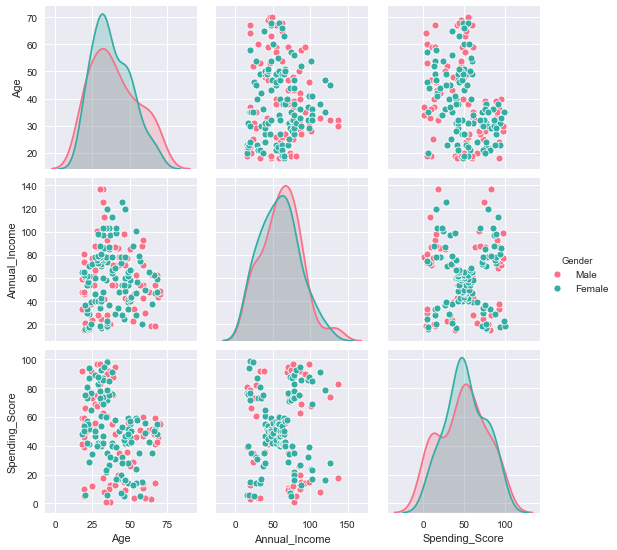

In [6]:
sns.pairplot(df, hue='Gender', palette='husl')

데이터가 전체적으로 성별과 큰 관계없이 분포해있음을 알 수 있다.

### Scatter Plot

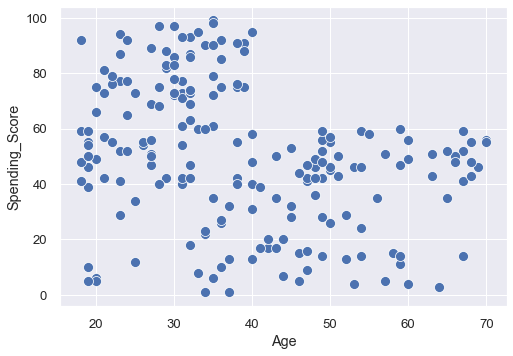

In [7]:
sns.set(font_scale=1.2)
sns.scatterplot(x='Age', y='Spending_Score', data=df, s=100)

데이터가 고르게 분포되어있다.

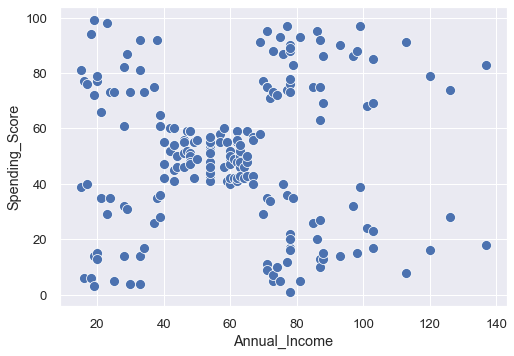

In [8]:
sns.set(font_scale=1.2)
sns.scatterplot(x='Annual_Income', y='Spending_Score', data=df, s=100)

데이터가 특이하게 X자 형태로 분포해있다.  
`Annual_Income`이 20에서 40인 소비자들은 `Spending_Score`가 높거나 낮은 정도에 있고,  
`Annual_Income`이 40에서 70인 소비자들은 `Spending_Score`가 중간 정도에 머물러있다.  
그러다가 `Annual_Income`이 70이상인 소비자들은 다시 `Spending_Score`가 높거나 낮게 (중간이 없게) 분포한다.  
분포가 양극단으로 나뉘었다가 중간으로 모였다가 다시 양극단으로 나누어진다.

### 데이터셋 구분

In [9]:
df1 = df[['Age','Spending_Score']].iloc[:,:].values
df2 = df[['Annual_Income','Spending_Score']].iloc[:,:].values

이번 분석에서는 (`Age`, `Spending_Score`), (`Annual_Income`, `Spending_Score`)를 가지고 clustering을 진행해보려 한다.

## 2. Clustering

## 1) Age, Spending_Score

### *K-means*  
  
Elbow Method를 이용하여 cluster의 개수를 선택하고 그에 따른 실루엣 점수를 관찰한다.

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [11]:
k = [2,3,4,5,6,7]
sil_score = []
k_inertia = []

for i in range(len(k)):
    kmeans = KMeans(n_clusters=k[i], init='k-means++', max_iter=10) 
    # init = 'k_means++' : 초기 클러스터 중심을 가능한 멀리 떨어지도록 만든다.
    # max_iter : 초기 중심위치 시도 횟수(default=10)
    kmeans.fit(df1)
    k_inertia.append(kmeans.inertia_) # inertia : 각 샘플과 가장 가까운 센트로이드 사이의 평균 제곱 거리
    sil_score.append(silhouette_score(df1, kmeans.labels_)) # 실루엣 점수로 최적 k 결정

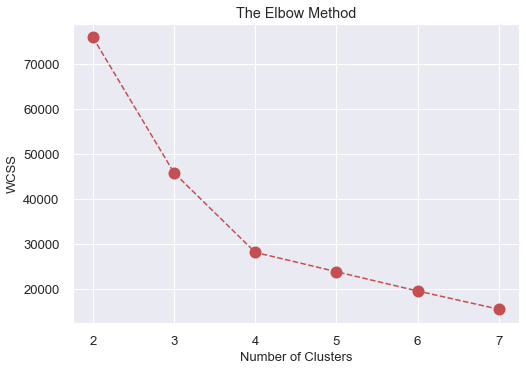

In [12]:
plt.plot(k, k_inertia, 'ro--', ms=12)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters', fontsize=13)
plt.ylabel('WCSS', fontsize=13)
plt.show()

WCSS가 완만하게 감소하기 시작하는 Cluster의 개수는 4이다.

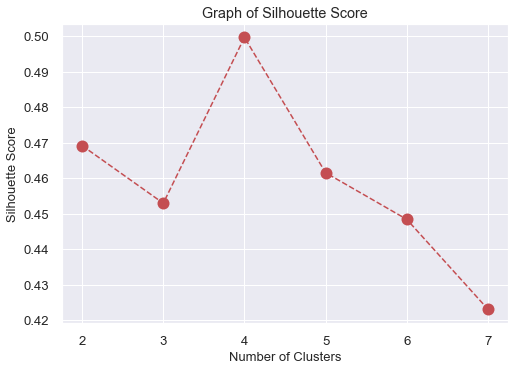

In [13]:
plt.plot(k, sil_score, 'ro--', ms=12)
plt.title('Graph of Silhouette Score')
plt.xlabel('Number of Clusters', fontsize=13)
plt.ylabel('Silhouette Score', fontsize=13)
plt.show()

또한 Cluster의 개수가 4일 때, 실루엣 점수가 압도적으로 좋다.  
  
**Number of Clusters = 4** 

In [14]:
kmeans_final = KMeans(n_clusters=4, init='k-means++', max_iter=10)
kmeans_final.fit(df1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [15]:
kmeans_final.labels_ # 분류된 Cluster의 인덱스. kmeans_final.predict(df1)와 같다.

array([0, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0, 0, 2, 3, 0, 3,
       2, 3, 2, 3, 2, 0, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 1, 3, 1, 0,
       2, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 3, 0, 3, 1, 3, 2, 3, 2, 3,
       0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0, 3, 2, 3, 1, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 1, 3, 2, 3, 2, 3, 2, 3, 2, 0, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3])

In [16]:
kmeans_final.cluster_centers_ # Centroid

array([[27.61702128, 49.14893617],
       [55.70833333, 48.22916667],
       [43.29166667, 15.02083333],
       [30.1754386 , 82.35087719]])

In [17]:
kmeans_final.score(df1) # 모델 스코어(=이너셔의 음수값) 반환. 큰 값이 좋은 것임을 의미해야 하기 때문에 음수로 반환됨.

-28165.58356662927

In [18]:
silhouette_score(df1, kmeans_final.labels_) # 실루엣 점수

0.49973941540141753

In [19]:
df11 = pd.DataFrame(df1)
cluster1 = pd.DataFrame(kmeans_final.labels_.reshape(-1,1))
cluster1 = cluster1.astype('object')

draw1 = pd.concat([df11, cluster1],axis=1)
draw1.columns = ['Age', 'Spending_Score', 'Cluster']

Text(0.5, 1.0, 'Scatter Plot of K-Means Clustering')

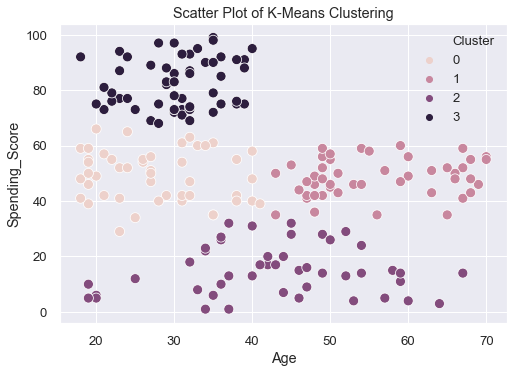

In [20]:
sns.set(font_scale=1.2)
ax = sns.scatterplot(x='Age', y='Spending_Score', hue='Cluster',data=draw1, s=100)
ax.set_title('Scatter Plot of K-Means Clustering')

### *Hierarchical Clustering*

In [21]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [22]:
Z = linkage(df1, 'ward') # Ward Method를 사용하여 계층적 군집화 실시
Z

array([[  1.        ,  35.        ,   0.        ,   2.        ],
       [ 12.        , 176.        ,   0.        ,   2.        ],
       [ 37.        , 159.        ,   0.        ,   2.        ],
       [154.        , 194.        ,   0.        ,   2.        ],
       [ 16.        ,  20.        ,   0.        ,   2.        ],
       [135.        , 183.        ,   0.        ,   2.        ],
       [147.        , 197.        ,   0.        ,   2.        ],
       [ 42.        , 146.        ,   0.        ,   2.        ],
       [  2.        , 134.        ,   1.        ,   2.        ],
       [  3.        ,  13.        ,   1.        ,   2.        ],
       [ 49.        ,  94.        ,   1.        ,   2.        ],
       [ 11.        ,  19.        ,   1.        ,   2.        ],
       [141.        , 163.        ,   1.        ,   2.        ],
       [123.        , 193.        ,   1.        ,   2.        ],
       [149.        , 179.        ,   1.        ,   2.        ],
       [ 38.        , 168

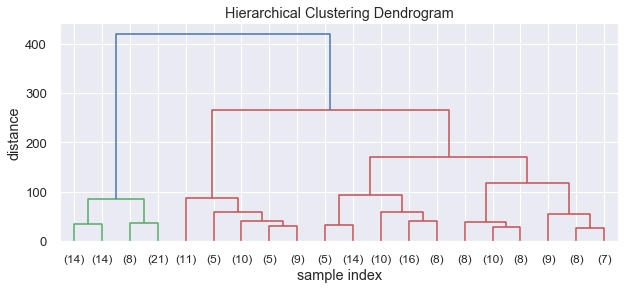

In [23]:
plt.figure(figsize=(10, 4))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
ddata = dendrogram(Z, truncate_mode='lastp', p=20) # p = 표시할 최대 cluster 개수. 

plt.show()

괄호 안의 숫자는 클러스터에 포함된 노드의 개수이다. 괄호가 없는 경우 단일 노드 클러스터를 의미한다.  
그렇다면 최적 n_cluster는 몇 개일까?

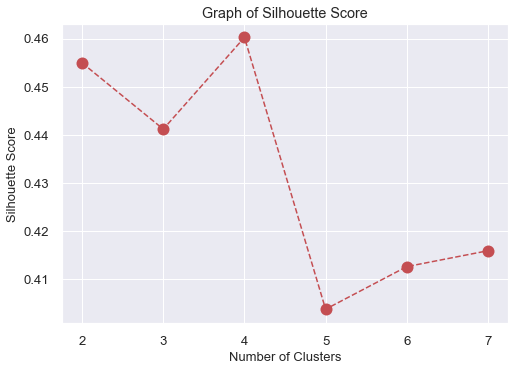

In [24]:
from sklearn.cluster import AgglomerativeClustering # 병합 군집 사용

n_cluster = [2,3,4,5,6,7]
sil_score = []

for i in range(len(n_cluster)):
    sil_score.append(silhouette_score(df1, AgglomerativeClustering(n_clusters=n_cluster[i]).fit_predict(df1)))
                     # 실루엣 점수로 최적 n_cluster 결정

plt.plot(n_cluster, sil_score, 'ro--', ms=12)
plt.title('Graph of Silhouette Score')
plt.xlabel('Number of Clusters', fontsize=13)
plt.ylabel('Silhouette Score', fontsize=13)
plt.show()

Cluster의 개수가 4일 때, 실루엣 점수가 가장 좋다.  
  
**Number of Clusters = 4** 

In [25]:
from scipy.cluster.hierarchy import cut_tree

num_of_cluster = 4
cluster_info = cut_tree(Z, num_of_cluster) # cluster 개수를 4개로 지정했을 때, 각 데이터별 cluster index 반환

In [26]:
silhouette_score(df1, AgglomerativeClustering(n_clusters=4).fit_predict(df1)) # 실루엣 점수

0.4602496389565028

### *DBSCAN*

In [28]:
from sklearn.cluster import DBSCAN # 병합 군집 사용

DBSCAN().fit_predict(df1)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

fit_predict의 결과(=label)가 -1일 경우 noise point를 의미한다.  
보다시피 DBSCAN의 hyperparameter 값을 default로 두고 하면 모든 데이터가 noise point로 결정된다.  

그래서 루프를 이용하여 최적의 eps값과 min_samples를 추정해보았다.

In [29]:
eps = np.arange(3, 7.1, 0.5) # 모든 데이터가 noise point로 분류되지 않기 시작하는 eps값부터 시작
min_samples = list(range(1, 7, 1))
sil_score = np.zeros((len(eps),len(min_samples))) # len(eps) = 9 (행 개수), len(min_samples) = 6 (열 개수)

for i in range(len(min_samples)):
    for j in range(len(eps)):
        sil_score[j][i] = silhouette_score(df1, DBSCAN(eps=eps[j], min_samples=min_samples[i], metric='euclidean').fit_predict(df1))
                     # metric : default
                     # 실루엣 점수로 최적 hyperparameter `eps`, 'min_samples' 결정

print(np.argmax(sil_score)) 
print(eps)
print(min_samples)

39
[3.  3.5 4.  4.5 5.  5.5 6.  6.5 7. ]
[1, 2, 3, 4, 5, 6]


Index 39가 의미하는 바 = 7행 4열 → `eps` = 6, `min_samples` = 4

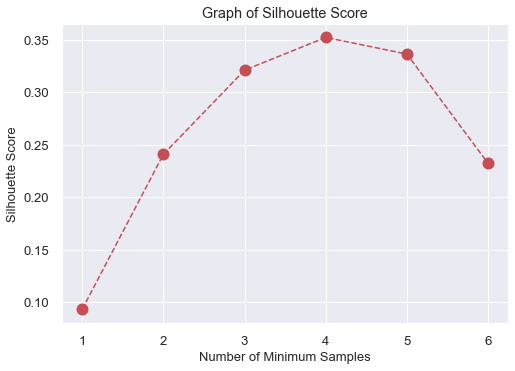

In [30]:
# eps=6 일 때 실루엣 점수 그래프

sil_score = []

for i in range(len(min_samples)):
    sil_score.append(silhouette_score(df1, DBSCAN(eps=6, min_samples=min_samples[i], metric='euclidean').fit_predict(df1)))

plt.plot(min_samples, sil_score, 'ro--', ms=12)
plt.title('Graph of Silhouette Score')
plt.xlabel('Number of Minimum Samples', fontsize=13)
plt.ylabel('Silhouette Score', fontsize=13)
plt.show()

실루엣 점수를 가장 크게 하는 hyperparameter 값은 `eps` = 6, `min_samples` = 4이다.  

In [31]:
DBSCAN(eps=6, min_samples=4, metric='euclidean').fit_predict(df1)

array([ 0,  1,  2,  1,  0,  1,  3,  1, -1,  1, -1,  1,  3,  1,  3,  1,  0,
        1,  0,  1,  0,  1,  3,  1,  3,  1,  0,  1,  0,  1, -1,  1, -1,  1,
        3,  1,  3,  1,  0,  1, -1,  1,  0,  1,  0,  1,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  1, -1,  1,  0,  1,  3,  1,  3,  1, -1,  1,  2,  1,
        3,  1,  2,  1, -1,  1,  0,  1, -1,  1,  0,  1,  0,  1,  3,  1,  3,
        1,  3,  1,  3,  1,  3,  1, -1,  1,  2,  1,  0,  1,  3,  1,  0,  1,
        3,  1,  3,  1,  3,  1,  3,  1,  3,  1,  0,  1,  3,  1,  0,  1,  0,
        1,  3,  1,  0,  1,  3,  1,  3,  1,  0,  1,  0,  1], dtype=int64)

**Number of Clusters = 4**

In [32]:
silhouette_score(df1, DBSCAN(eps=6, min_samples=4, metric='euclidean').fit_predict(df1)) # 실루엣 점수

0.35248095830808085

## 2) Annual_Income, Spending_Score

### *K-means*  
  
Elbow Method를 이용하여 cluster의 개수를 선택하고 그에 따른 실루엣 점수를 관찰한다.

In [33]:
k = [2,3,4,5,6,7]
sil_score = []
k_inertia = []

for i in range(len(k)):
    kmeans = KMeans(n_clusters=k[i], init='k-means++', max_iter=10) 
    # init = 'k_means++' : 초기 클러스터 중심을 가능한 멀리 떨어지도록 만든다.
    # max_iter : 초기 중심위치 시도 횟수(default=10)
    kmeans.fit(df2)
    k_inertia.append(kmeans.inertia_) # inertia : 각 샘플과 가장 가까운 센트로이드 사이의 평균 제곱 거리
    sil_score.append(silhouette_score(df2, kmeans.labels_)) # 실루엣 점수로 최적 k 결정

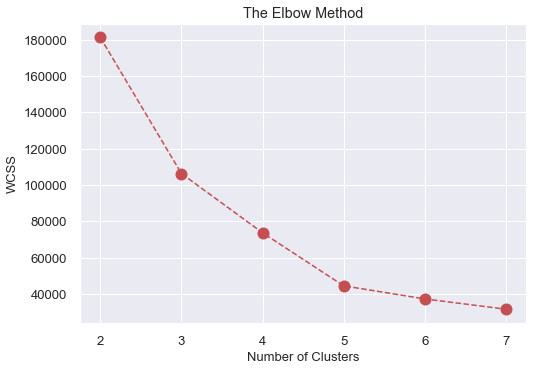

In [34]:
plt.plot(k, k_inertia, 'ro--', ms=12)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters', fontsize=13)
plt.ylabel('WCSS', fontsize=13)
plt.show()

WCSS가 완만하게 감소하기 시작하는 Cluster의 개수는 5이다.

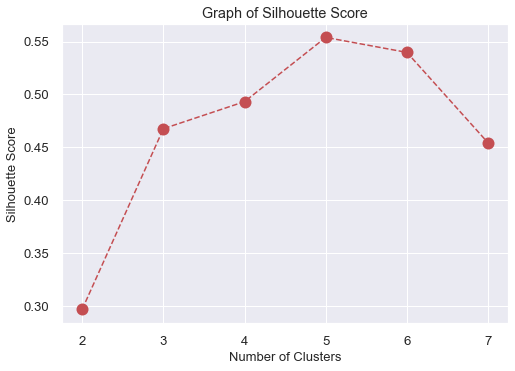

In [35]:
plt.plot(k, sil_score, 'ro--', ms=12)
plt.title('Graph of Silhouette Score')
plt.xlabel('Number of Clusters', fontsize=13)
plt.ylabel('Silhouette Score', fontsize=13)
plt.show()

또한 Cluster의 개수가 5일 때, 실루엣 점수가 압도적으로 좋다.  
  
**Number of Clusters = 5** 

In [36]:
kmeans_final2 = KMeans(n_clusters=5, init='k-means++', max_iter=10)
kmeans_final2.fit(df2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [37]:
kmeans_final2.labels_ # 분류된 Cluster의 인덱스. kmeans_final.predict(df2)와 같다.

array([1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4,
       1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 0,
       1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 2, 3, 2, 3, 2,
       0, 2, 3, 2, 3, 2, 3, 2, 3, 2, 0, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2,
       3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2,
       3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2,
       3, 2])

In [38]:
kmeans_final2.cluster_centers_ # Centroid

array([[55.2962963 , 49.51851852],
       [26.30434783, 20.91304348],
       [86.53846154, 82.12820513],
       [88.2       , 17.11428571],
       [25.72727273, 79.36363636]])

In [39]:
kmeans_final2.score(df2) # 모델 스코어 (=이너셔의 음수값) 반환. 

-44448.45544793379

In [40]:
silhouette_score(df2, kmeans_final2.labels_) #실루엣 점수

0.553931997444648

In [41]:
df22 = pd.DataFrame(df2)
cluster2 = pd.DataFrame(kmeans_final2.labels_.reshape(-1,1))
cluster2 = cluster2.astype('object')

draw2 = pd.concat([df22, cluster2],axis=1)
draw2.columns = ['Annual_Income', 'Spending_Score', 'Cluster']

Text(0.5, 1.0, 'Scatter Plot of K-Means Clustering')

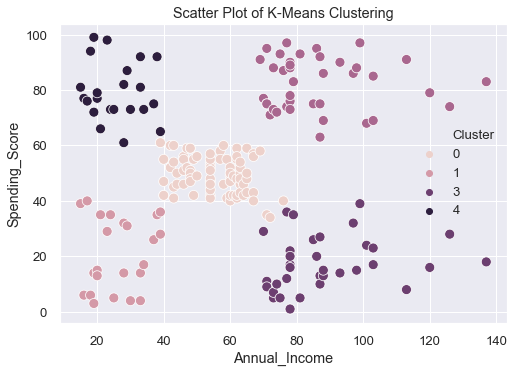

In [42]:
sns.set(font_scale=1.2)
ax = sns.scatterplot(x='Annual_Income', y='Spending_Score', hue='Cluster',data=draw2, s=100)
ax.set_title('Scatter Plot of K-Means Clustering')

총 5개의 cluster로 분류하였는데 legend에는 4개만 나오네요! 오른쪽 아래에 있는 cluster가 2번 cluster입니다. 참고해주세요!

### *Hierarchical Clustering*

In [43]:
Z2 = linkage(df2, 'ward') # Ward Method를 사용하여 계층적 군집화 실시
Z2

array([[ 65.        ,  68.        ,   0.        ,   2.        ],
       [ 48.        ,  49.        ,   0.        ,   2.        ],
       [156.        , 158.        ,   0.        ,   2.        ],
       [129.        , 131.        ,   0.        ,   2.        ],
       [ 21.        ,  23.        ,   1.        ,   2.        ],
       [ 51.        ,  53.        ,   1.        ,   2.        ],
       [ 60.        ,  61.        ,   1.        ,   2.        ],
       [ 67.        ,  69.        ,   1.        ,   2.        ],
       [ 64.        ,  66.        ,   1.        ,   2.        ],
       [ 79.        ,  82.        ,   1.        ,   2.        ],
       [ 74.        ,  85.        ,   1.        ,   2.        ],
       [ 78.        ,  80.        ,   1.        ,   2.        ],
       [ 75.        ,  81.        ,   1.        ,   2.        ],
       [ 92.        ,  97.        ,   1.        ,   2.        ],
       [101.        , 109.        ,   1.        ,   2.        ],
       [107.        , 113

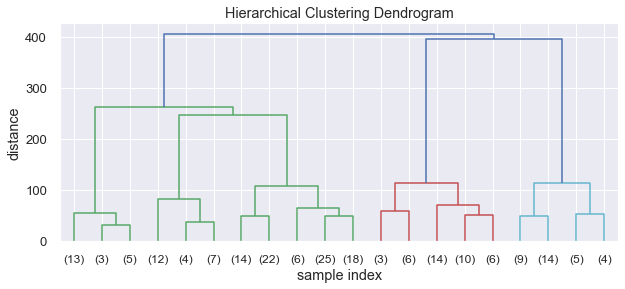

In [44]:
plt.figure(figsize=(10, 4))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
ddata = dendrogram(Z2, truncate_mode='lastp', p=20) # p = 표시할 최대 cluster 개수. 

plt.show()

괄호 안의 숫자는 클러스터에 포함된 노드의 개수이다. 괄호가 없는 경우 단일 노드 클러스터를 의미한다.  
그렇다면 최적 n_cluster는 몇 개일까?

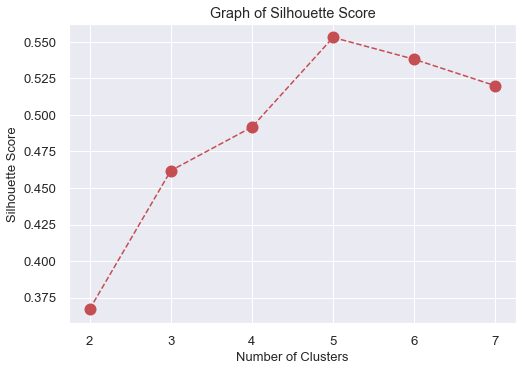

In [45]:
from sklearn.cluster import AgglomerativeClustering # 병합 군집 사용

n_cluster = [2,3,4,5,6,7]
sil_score = []

for i in range(len(n_cluster)):
    sil_score.append(silhouette_score(df2, AgglomerativeClustering(n_clusters=n_cluster[i]).fit_predict(df2)))
                     # 실루엣 점수로 최적 n_cluster 판단

plt.plot(n_cluster, sil_score, 'ro--', ms=12)
plt.title('Graph of Silhouette Score')
plt.xlabel('Number of Clusters', fontsize=13)
plt.ylabel('Silhouette Score', fontsize=13)
plt.show()

Cluster의 개수가 5일 때, 실루엣 점수가 가장 좋다.  
  
**Number of Clusters = 5** 

In [46]:
from scipy.cluster.hierarchy import cut_tree
num_of_cluster = 5
cluster_info = cut_tree(Z2, num_of_cluster) # cluster 개수를 5개로 지정했을 때, 각 데이터별 cluster index 반환

In [47]:
silhouette_score(df2, AgglomerativeClustering(n_clusters=5).fit_predict(df2)) # 실루엣 점수

0.5529945955148897

### *DBSCAN*

In [48]:
DBSCAN().fit_predict(df2)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

`Age`, `Spending_Score` 분석 때와 마찬가지로 모든 데이터가 noise point로 분류되었다.  

그래서 루프를 이용하여 최적의 eps값과 min_samples를 추정해보았다.

In [49]:
len(min_samples)

6

In [50]:
eps = np.arange(5, 9.1, 0.5) # 모든 데이터가 noise point로 분류되지 않기 시작하는 eps값부터 시작
min_samples = list(range(1, 9, 1))
sil_score = np.zeros((len(eps),len(min_samples))) # len(eps) = 9 (행 개수), len(min_samples) = 8 (열 개수)

for i in range(len(min_samples)):
    for j in range(len(eps)):
        sil_score[j][i] = silhouette_score(df2, DBSCAN(eps=eps[j], min_samples=min_samples[i], metric='euclidean').fit_predict(df2))
                     # metric : default
                     # 실루엣 점수로 최적 hyperparameter `eps`, 'min_samples' 결정

print(np.argmax(sil_score)) 
print(eps)
print(min_samples)

66
[5.  5.5 6.  6.5 7.  7.5 8.  8.5 9. ]
[1, 2, 3, 4, 5, 6, 7, 8]


Index 66가 의미하는 바 = 9행 3열 → `eps` = 9, `min_samples` = 3

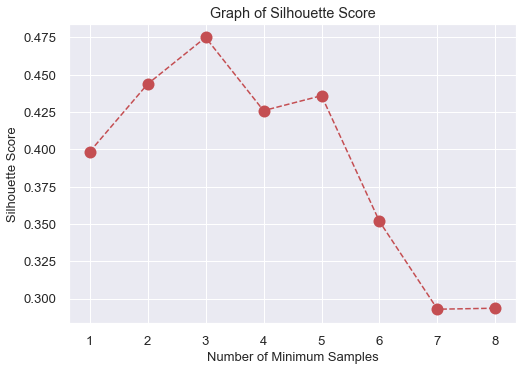

In [51]:
# eps=9 일 때 실루엣 점수 그래프

sil_score = []

for i in range(len(min_samples)):
    sil_score.append(silhouette_score(df2, DBSCAN(eps=9, min_samples=min_samples[i], metric='euclidean').fit_predict(df2)))

plt.plot(min_samples, sil_score, 'ro--', ms=12)
plt.title('Graph of Silhouette Score')
plt.xlabel('Number of Minimum Samples', fontsize=13)
plt.ylabel('Silhouette Score', fontsize=13)
plt.show()

실루엣 점수를 가장 크게 하는 hyperparameter 값은 `eps` = 9, `min_samples` = 3이다.  

In [52]:
DBSCAN(eps=9, min_samples=3, metric='euclidean').fit_predict(df2)

array([ 0,  1,  2,  1,  0,  1,  2,  3,  2,  1,  2,  3,  2,  1,  2,  1,  0,
        1,  0,  3,  0,  1,  2,  1,  2,  1,  0,  1,  0,  1,  2,  1,  2,  1,
        2,  1,  2,  1,  4,  1,  4,  1,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  5,  4,  5,  4,  5,  6,  5,  6,  5,  4,  5,  6,  5,
        6,  5,  6,  5,  6,  5,  4,  5,  6,  5,  4,  5,  6,  5,  6,  5,  6,
        5,  6,  5,  6,  5,  6,  5,  4,  5,  6,  5,  6,  5,  6,  5,  6,  5,
        6,  5,  6,  5,  6,  5,  6,  5,  6,  5,  6,  5,  6,  5,  6, -1,  6,
       -1,  6,  5,  6, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

**Number of Clusters = 7**

In [53]:
silhouette_score(df2, DBSCAN(eps=9, min_samples=3, metric='euclidean').fit_predict(df2)) # 실루엣 점수

0.475053701963407

## 3. Evaluation  
  
Dunn Index > 1 or Silhouette Score > 0.5 → 적절한 클러스터링  
위에서 구한 Silhouette Score를 다시 정리해보면 다음과 같다.

### 1) Age, Spending_Score

Model | Hyperparameter | Silhouette Score | Explanation
:-: | :-: | :-: | :-
K-Means | n_clusters = 4 | 0.4997 | Not Bad
Hierarchical | n_clusters = 4 | 0.4603 | Not Bad
DBSCAN | eps = 6, min_samples = 4 | 0.3525 | 클러스터링 결과, n_clusters = 4.  eps의 default값이 0.5인 것에 비해 clustering 기준을 지나치게 완화시킨 경향이 있다.

### 2) Annual_Income, Spending_Score

Model | Hyperparameter | Silhouette Score | Explanation
:-: | :-: | :-: | :-
K-Means | n_clusters = 5 | 0.5539 | Good
Hierarchical | n_clusters = 5 | 0.553 | Good
DBSCAN | eps = 9, min_samples = 3 | 0.475 | Not Bad. 클러스터링 결과, n_clusters = 7.  eps의 default값이 0.5인 것에 비해 clustering 기준을 지나치게 완화시킨 경향이 있다.

## 4. Key Point

* 하이퍼파라미터가 두 개 이상인 DBSCAN을 보고 GridSearchCV를 이용해볼까 했지만, 비지도학습의 경우 CV를 진행하지 않기 때문에 GridSearchCV를 이용하지 않음을 알게 되었다.  
* 좀 더 공부해서 `Age`, `Annual_Income`, `Spending_Score` 를 함께 clustering 하는 다차원 clustering도 시도해보면 좋을 것 같다.